In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time
from matplotlib import pyplot as plt
import scipy as sp
import numpy as np

========> 2000 25 4.9999999999999995e-11 1e-07 64.00000000000001


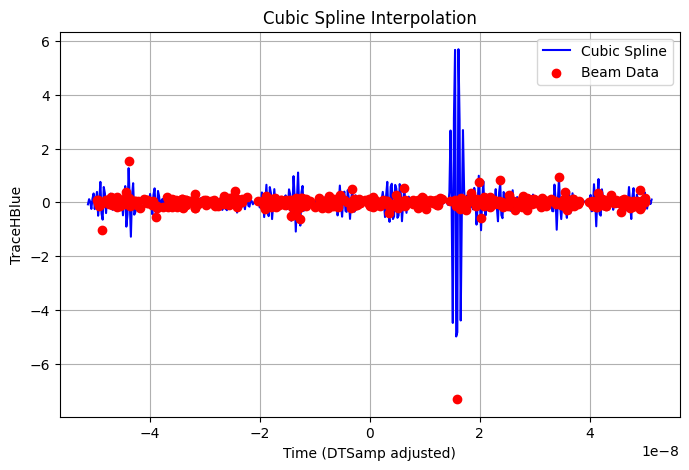

The initial emittance is 0.8941292449088719π mm*mrad
The final emittance after cooling is 0.04377889412084156π mm*mrad
Is emittance reduced? -->  True
Emittance is reduced by 95.1037398261922%
The initial rms_momentum_spread is 0.0009928427504854972 
The final rms_momentum_spread after cooling is 0.0003967434555663077 
Is rms_momentum_spread reduced? -->  True
rms_momentum_spread is reduced by 60.039648235100536%


 =======> duration of run 1152.07 s <===



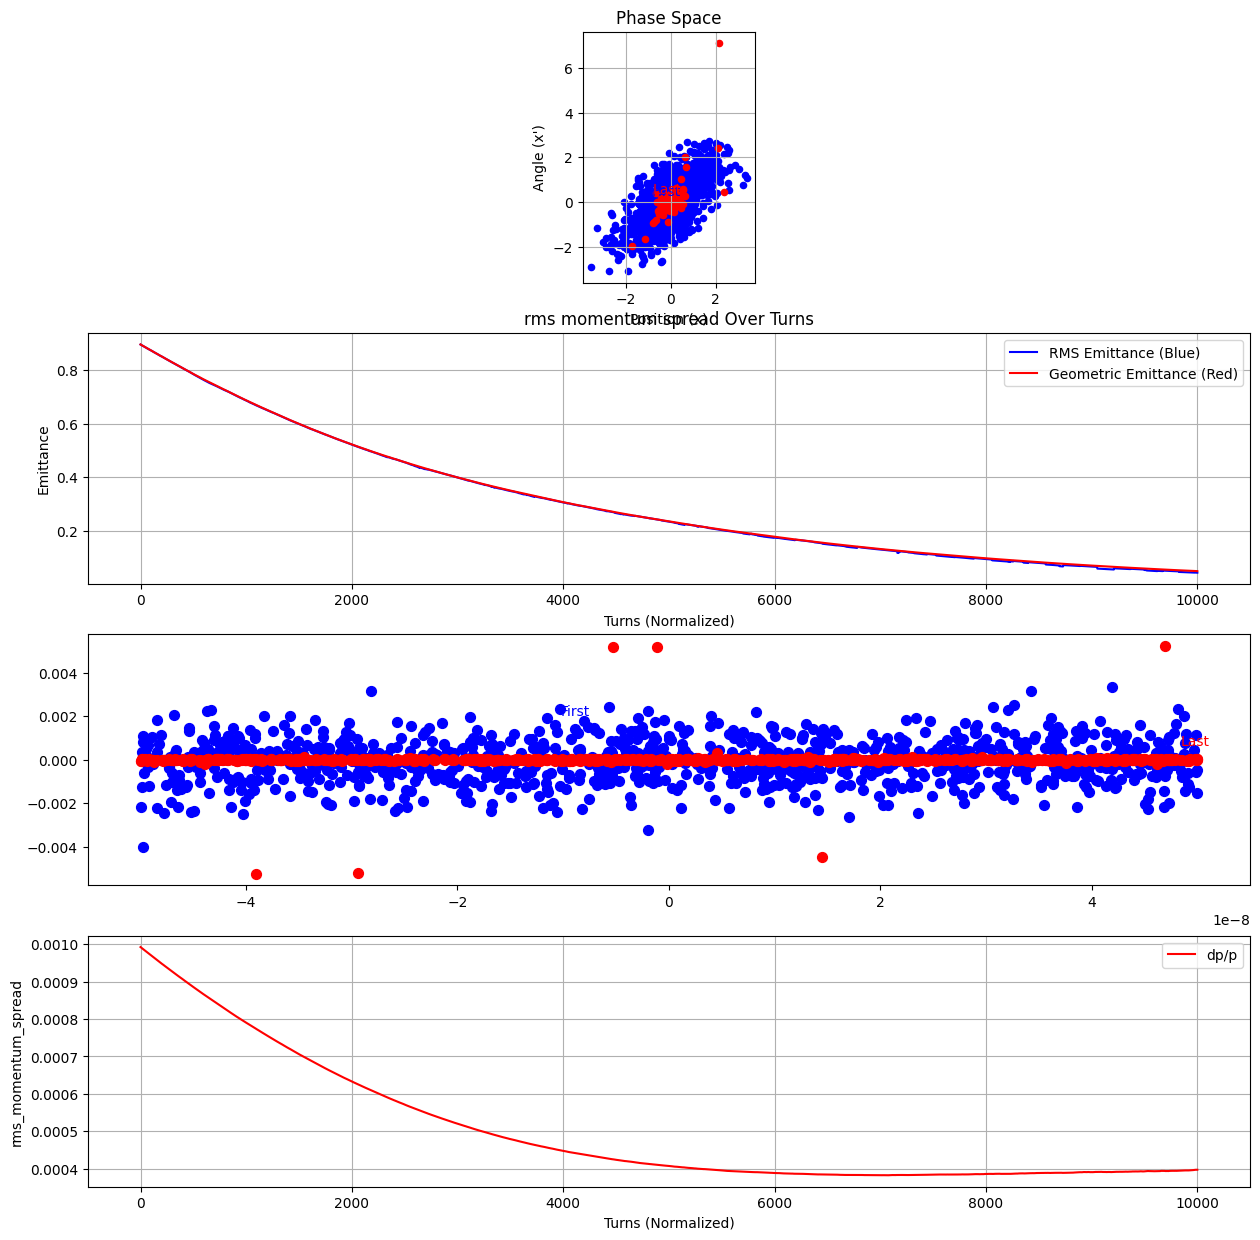

In [2]:
#time delay cooling here!~!!!!!1

datin  = time.time()  # record start time - to estimate run duration at end

Nparts, Nturns =  1000, 10000  
betPU, alfPU       =  1.3, -0.9
betK, alfK         =  0.8,  0.6
gamPU, gamK        =  (1 + alfPU**2)/betPU, (1 + alfK**2)/betK
muPUK, muKPU       =  1.51, 2*np.pi*1.34 - 1.51
total_angle        =  2*np.pi*1.34
etaPUK, etaKPU     =  0.03, 0.03     #eta PUK must be reletevely small, so they dont change slices so fast... 0.02 breaks the system ... It is the limit case!!!! very sensitive on etaPUK --> 2 much unwanted mixing, also etaKPU cant go very low(limit case 0.3) because then the mixing is bad
sigdelt            = .001            # rms momentum spread in unit
Th, Trev           =  .1e-6, 5.0e-6, # half width of simulation window and revolution period in s
Tovlap, NSamp, add = 4*sigdelt*(etaPUK + etaKPU)*Trev, 2000, '2000'
gain               =  0.0005  #as long as I reduce the eta, i have to reduce gains as well... see book
gainL              =  0.00000005
#np.random.seed(54)

"""
wlH, wrH = -1.6e-9, 1.6e-9
def respH(Dt):
    if Dt < 1. * wlH or Dt > 1. * wrH:
        print(f' ===> function respH called with Dt ={1e6*Dt:8.4f}')
    return 0.5 * (1 + np.cos((2 * np.pi / wrH) * Dt))


"""
emittance_individual_particles = np.zeros((Nturns+2, 10))
# definition of the transverse "response function", which is given by the 
#    routine resp for the interval -wlH < Dt < wrH and 0 outside
wlH, wrH = -1.6e-9, 1.6e-9
def respH( Dt ):
    if Dt < 1.*wlH or Dt > 1.*wrH:
        print( f' ===> function respH called with Dt ={1e6*Dt:8.4f}' )
    return (1 - 27e18*Dt**2)*(1 - 3.e18*Dt**2)*(1 - 1.15e18*Dt**2)*(1 - (.625e9*Dt)**2)**7
#   return (1 - 23e16*Dt**2)*(1 - 3.e16*Dt**2)*(1 - 1.15e16*Dt**2)*(1 - (.625e8*Dt)**2)**7
#   return (1 - 25e-12*Dt^2)*(1 - 3e-12*Dt^2)*(1 - 1.15e-12*Dt^2)*(1 - (Dt/1.5)^2)^6

wlL, wrL = -1.6e-9, 1.6e-9
def respL( Dt ):
    if Dt < 1.*wlL or Dt > 1.*wrL:
        print( f' ===> function respL called with Dt ={1e6*Dt:8.4f}' )
    return (63e9*Dt)*(1 - 6.5e18*Dt**2)*(1 - 1.55e18*Dt**2)*(1 - (.625e9*Dt)**2)**8

#rng = np.random.default_rng(18022005)
rng = np.random.default_rng(2207205654 )   #this gives us the random seed!!!!

# Total width (particles of both colors) of beam time window is 2*Th ('h' for half)
#  for sampling each sub-window (red or blue) divided into NSamp intervals. This
#  means samp,ing rate DTsamp and NSamp + 1 points. On both ends to be added 
#  ceiling( Tovlap/DTSamp ) points   
DTSamp   = Th/NSamp
NSampext = math.ceil( Tovlap/DTSamp )

print('========>', NSamp, NSampext, DTSamp, Th, (wrH - wlH)/DTSamp)

# Routine to do do the exchange of .. ended up by regrouping from scratch
def PartsExchange( ptsEarly, ptsLate ):
    ptsEarlyNew, ptsLateNew = [], []
    for x, xp, delt, Tau in ptsEarly:
        if Tau < Th/2:  # should remain in "early group
            ptsEarlyNew += [ [x, xp, delt, Tau] ]
        else:
            ptsLateNew += [ [x, xp, delt, Tau - Th] ]
    for x, xp, delt, Tau in ptsLate:
        if Tau > -Th/2:
            ptsLateNew += [ [x, xp, delt, Tau] ]
        else:
            ptsEarlyNew += [ [x, xp, delt, Tau + Th] ]
    return ptsEarlyNew, ptsLateNew

# Routine to generate time traces
def TimeTraces( ptsEarly, ptsMain, ptsLate ):
    TraceH = [ 0. for _ in range(NSamp + 1 + 2*NSampext) ]
    TraceL = [ 0. for _ in range(NSamp + 1 + 2*NSampext) ]
#   first generate transverse trace
    for x, xp, delt, Tau in ptsEarly:    #precious slice than the one under investigation
        for ind in range( max(-NSampext, math.ceil((wlH+Tau-Th+Th/2)/DTSamp)), 
                          min(NSamp+1+NSampext, math.ceil((wrH+Tau-Th+Th/2)/DTSamp)) ):
            TraceH[ind] += x*respH(ind*DTSamp -Th/2- (Tau-Th) )
    for x, xp, delt, Tau in ptsMain:     #slice under investigation
        for ind in range( max(-NSampext, math.ceil((wlH+Tau+Th/2)/DTSamp)), 
                          min(NSamp+1+NSampext, math.ceil((wrH+Tau+Th/2)/DTSamp)) ):
            TraceH[ind] += x*respH(ind*DTSamp-Th/2 - Tau )
    for x, xp, delt, Tau in ptsLate:       #next slice un h) )
        for ind in range( max(-NSampext, math.ceil((wlH+Tau+Th+Th/2)/DTSamp)), 
                          min(NSamp+1+NSampext, math.ceil((wrH+Tau+Th+Th/2)/DTSamp)) ):
            TraceH[ind] += x*respH(ind*DTSamp -Th/2- (Tau+Th) )
    for x, xp, delt, Tau in ptsEarly:
        for ind in range( max(-NSampext, math.ceil((wlL+Tau-Th+Th/2)/DTSamp)), 
                          min(NSamp+1+NSampext, math.ceil((wrL+Tau-Th+Th/2)/DTSamp)) ):
            TraceL[ind] += respL(ind*DTSamp -Th/2- (Tau-Th) )
    for x, xp, delt, Tau in ptsMain:
        for ind in range( max(-NSampext, math.ceil((wlL+Tau+Th/2)/DTSamp)), 
                          min(NSamp+1+NSampext, math.ceil((wrL+Tau+Th/2)/DTSamp)) ):
            TraceL[ind] += respL(ind*DTSamp -Th/2- Tau )
    for x, xp, delt, Tau in ptsLate:
        for ind in range( max(-NSampext, math.ceil((wlL+Tau+Th+Th/2)/DTSamp)), 
                          min(NSamp+1+NSampext, math.ceil((wrL+Tau+Th+Th/2)/DTSamp)) ):
            TraceL[ind] += respL(ind*DTSamp -Th/2- (Tau+Th) )
    return TraceH, TraceL

def kickH(pts, signalH):
    corrected_pts = []
    for x, xp, delt, Tau in pts:
        # Interpolate signalH at the particle's Tau
        signal_value = signalH(Tau)
        # Correct xp using the signal value (define your correction logic)
        corrected_xp = xp +gain * signal_value  # I add the signal!!!!!
        # Append the updated particle to the new list
        corrected_pts.append([x, corrected_xp, delt, Tau])
    return corrected_pts

def kickL(pts, signalL):
    corrected_pts = []
    for x, xp, delt, Tau in pts:
        # Interpolate signalL at the particle's Tau
        signal_value = signalL(Tau)
        # Correct xp using the signal value (define your correction logic)
        corrected_delt = delt - gainL * signal_value  # Example: subtracting scaled signal
        # Append the updated particle to the new list
        corrected_pts.append([x, xp, corrected_delt, Tau])
    return corrected_pts


# Computation of transverse transfer matrix elements
projPU11 =  betPU**(1/2)
projPU21 = -alfPU/betPU**(1/2)
projPU22 =  1/betPU**(1/2)

matPUK11 = ((betK/betPU)**(1/2))*(np.cos(muPUK) + alfPU*np.sin(muPUK))
matPUK12 = ((betPU*betK)**(1/2))*np.sin(muPUK)
matPUK21 = ((alfPU-alfK)*np.cos(muPUK) - (1+alfPU*alfK)*np.sin(muPUK))/((betPU*betK)**(1/2))
matPUK22 = ((betPU/betK)**(1/2))*(np.cos(muPUK) - alfK*np.sin(muPUK))

matKPU11 = ((betPU/betK)**(1/2))*(np.cos(muKPU) + alfK*np.sin(muKPU))
matKPU12 = ((betPU*betK)**(1/2))*np.sin(muKPU)
matKPU21 = ((alfK-alfPU)*np.cos(muKPU) - (1+alfPU*alfK)*np.sin(muKPU))/((betPU*betK)**(1/2))
matKPU22 = ((betK/betPU)**(1/2))*(np.cos(muKPU) - alfPU*np.sin(muKPU))

# Generate macroparticles in two groups with red ones and blue ones
#    .. say we start with red particles the early ones
ptsRed  = []
ptsBlue = []
for _ in range(Nparts):
    Tau = rng.uniform(-Th, Th)
    xn, xpn, deltn = rng.normal(0., 1.), rng.normal(0., 1.), rng.normal(0., 1.)
    if Tau < 0: 
        ptsRed += [ [projPU11*xn, projPU21*xn + projPU22*xpn, 
                     deltn*sigdelt, Tau + Th/2] ]
    else:
        ptsBlue += [ [projPU11*xn, projPU21*xn + projPU22*xpn, 
                      deltn*sigdelt, Tau - Th/2] ]


emittance=np.zeros(Nturns+2)
geo_emittance=np.zeros(Nturns+2)
beam=[]
xp_beam=[]
x_beam=[]
beam=ptsRed+ptsBlue
beam = np.array(beam)
x_beam=beam[:,0]
xp_beam=beam[:,1]
x_initial=x_beam
xp_initial=xp_beam
tau_initial=beam[:,3]
delt_initial=beam[:,2]
emittance[0]=np.sqrt(np.mean(x_initial**2)*np.mean(xp_initial**2)-np.mean(x_initial*xp_initial)**2)   
geo_emittance[0]=((gamPU*np.mean(x_initial**2)+2*alfPU*np.mean(x_initial*xp_initial)+betPU*np.mean(xp_initial**2)))/2
emittance_individual_particles[0][:]=(gamPU*x_beam[:10]**2+2*alfPU*(x_beam[:10]*xp_beam[:10])+betPU*(xp_beam[:10]**2))/2



# Track red (now early) particles ones once around
ptsRedprev = ptsRed
ptsRed = [ [matPUK11*x + matPUK12*xp, matPUK21*x + matPUK22*xp, delt, 
            Tau + etaPUK*delt*Trev] for x, xp, delt, Tau in ptsRed ]  # no action at kicker
ptsRed = [ [matKPU11*x + matKPU12*xp, matKPU21*x + matKPU22*xp, delt, 
            Tau + etaKPU*delt*Trev] for x, xp, delt, Tau in ptsRed]

# Prepare for tracking of blue particles and track them once around
ptsBlue, ptsRed = PartsExchange( ptsBlue, ptsRed )
ptsBlueprev = ptsBlue
TrHBlue, TrLBlue = TimeTraces( ptsRedprev, ptsBlue, ptsRed )
cs = sp.interpolate.CubicSpline( DTSamp*np.arange(-NSampext, NSamp + 1 + NSampext), 
                  TrHBlue[-NSampext:] + TrHBlue[:NSamp + 1 + NSampext] )
ptsBlue = [ [matPUK11*x + matPUK12*xp, matPUK21*x + matPUK22*xp, delt, 
            Tau + etaPUK*delt*Trev] for x, xp, delt, Tau in ptsBlue ]  # no action at kicker
#ptsBlue=kickH(ptsBlue,cs)
ptsBlue = [ [matKPU11*x + matKPU12*xp, matKPU21*x + matKPU22*xp, delt, 
            Tau + etaKPU*delt*Trev] for x, xp, delt, Tau in ptsBlue]

# Prepare for 2nd tracking of red particles and track them once around
ptsRed, ptsBlue = PartsExchange( ptsRed, ptsBlue )
ptsRedprev = ptsRed
TrHRed, TrLRed = TimeTraces( ptsBlueprev, ptsRed, ptsBlue )
#cs = sp.interpolate.CubicSpline( DTSamp*np.arange(-NSampext, NSamp + 1 + NSampext)-Th/2, 
 #                 TrHRed[-NSampext:] + TrHRed[:NSamp + 1 + NSampext] )
ptsRed = [ [matPUK11*x + matPUK12*xp, matPUK21*x + matPUK22*xp, delt, 
            Tau + etaPUK*delt*Trev] for x, xp, delt, Tau in ptsRed ]  # no action at kicker
#ptsRed=kickH(ptsRed,cs)
ptsRed = [ [matKPU11*x + matKPU12*xp, matKPU21*x + matKPU22*xp, delt, 
            Tau + etaKPU*delt*Trev] for x, xp, delt, Tau in ptsRed]

# Now the blue ones are early - now just enter loop over number of turns
#   later - for longitudinal filter cooling - some more tracking will be needed

beam=[]
xp_beam=[]
x_beam=[]
beam=ptsRed+ptsBlue
beam = np.array(beam)
x_beam=beam[:,0]
xp_beam=beam[:,1]
emittance[1]=np.sqrt(np.mean(x_beam**2)*np.mean(xp_beam**2)-np.mean(x_beam*xp_beam)**2) 
emittance_individual_particles[1][:]=(gamPU*x_beam[:10]**2+2*alfPU*(x_beam[:10]*xp_beam[:10])+betPU*(xp_beam[:10]**2))/2
rms_momentum_spread=np.zeros(Nturns)

# Now we can go in loop and even implement transverse cooling or longitudinal time delay cooling (but not filter)
for turn in range(Nturns):
    #print(f' turn {turn:5d} after {(time.time() - datin):8.2f} s <===')
#   Get ready for the blue particles to be tracked and track them to kicker
    ptsBlue, ptsRed = PartsExchange( ptsBlue, ptsRed )
    ptsBlueprev, TrLBlueprev = ptsBlue, TrLBlue  # Keep longitudinal trace to add filter cooling later
    TrHBlue, TrLBlue = TimeTraces( ptsRedprev, ptsBlue, ptsRed )
    cs = sp.interpolate.CubicSpline( DTSamp*np.arange(-NSampext, NSamp + 1 + NSampext)-Th/2, 
                  TrHBlue[-NSampext:] + TrHBlue[:NSamp + 1 + NSampext] )
    csL=sp.interpolate.CubicSpline( DTSamp*np.arange(-NSampext, NSamp + 1 + NSampext)-Th/2, 
                  TrLBlue[-NSampext:] + TrLBlue[:NSamp + 1 + NSampext] )
    #cs = sp.interpolate.interp1d( DTSamp*np.arange(-NSampext, NSamp + 1 + NSampext)-Th/2, 
     #             TrHBlue[-NSampext:] + TrHBlue[:NSamp + 1 + NSampext] )
    #csL=sp.interpolate.interp1d( DTSamp*np.arange(-NSampext, NSamp + 1 + NSampext)-Th/2, 
     #             TrLBlue[-NSampext:] + TrLBlue[:NSamp + 1 + NSampext] )

    #print(len(TrHBlue))
    ptsBlue = [ [matPUK11*x + matPUK12*xp, matPUK21*x + matPUK22*xp, delt, 
                 Tau + etaPUK*delt*Trev] for x, xp, delt, Tau in ptsBlue ]
#   One day cooling to be applied -  now just dump time traces instead
    ptsBlue=kickH(ptsBlue,cs)
    ptsBlue=kickL(ptsBlue,csL)
#   track the blue one further to the PU
    ptsBlue = [ [matKPU11*x + matKPU12*xp, matKPU21*x + matKPU22*xp, delt, 
                 Tau + etaKPU*delt*Trev] for x, xp, delt, Tau in ptsBlue ]
#   Get ready for the red particles to be tracked and track them to kicker
    ptsRed, ptsBlue = PartsExchange( ptsRed, ptsBlue )
    ptsRedprev, TrLRedprev = ptsRed, TrLRed  # Keep longitudinal trace to add filter cooling later
    TrHRed, TrLRed = TimeTraces( ptsBlueprev, ptsRed, ptsBlue )
    cs = sp.interpolate.CubicSpline( DTSamp*np.arange(-NSampext, NSamp + 1 + NSampext)-Th/2, 
                  TrHRed[-NSampext:] + TrHRed[:NSamp + 1 + NSampext] )
    csL=sp.interpolate.CubicSpline( DTSamp*np.arange(-NSampext, NSamp + 1 + NSampext)-Th/2, 
                  TrLRed[-NSampext:] + TrLRed[:NSamp + 1 + NSampext] )
    x_vals = np.linspace(-Th/2 - NSampext * DTSamp, (NSamp + NSampext) * DTSamp - Th/2, 500)
    y_vals = cs(x_vals)
    #print("Spline Knots:", cs.x)  # Knots where the spline pieces join
    #print("Spline Coefficients:", cs.c)  # Coefficients of the spline pieces
   
    tauPU=[]
    xPU=[]
    beam=ptsRed
    beam = np.array(beam)
    tauPU=beam[:,3]
    xPU=beam[:,0]
    
# Plot the spline
    if turn==Nturns-1:
     plt.figure(figsize=(8, 5))
     plt.plot(x_vals, y_vals, label='Cubic Spline', color='blue')
    #plt.scatter(cs.x, cs(cs.x), color='red', label='Data Points', zorder=5)  # Interpolated points
     plt.scatter(tauPU,xPU, color='red', label='Beam Data', zorder=5)  # Use scatter for point data
     plt.title('Cubic Spline Interpolation')
     plt.xlabel('Time (DTSamp adjusted)')
     plt.ylabel('TraceHBlue')
     plt.legend()
     plt.grid(True)
     plt.show()

     
    ptsRed = [ [matPUK11*x + matPUK12*xp, matPUK21*x + matPUK22*xp, delt, 
                Tau + etaPUK*delt*Trev] for x, xp, delt, Tau in ptsRed ]
#   One day cooling(s) to be applied - now just dump time traces instead
    ptsRed=kickH(ptsRed,cs)
    ptsRed=kickL(ptsRed,csL)   #time of flight method longitudinal cooling
#   track the red ones further to the PU, where they will be the late ones
    ptsRed = [ [matKPU11*x + matKPU12*xp, matKPU21*x + matKPU22*xp, delt, 
                Tau + etaKPU*delt*Trev] for x, xp, delt, Tau in ptsRed ] 
    beam=[]
    xp_beam=[]
    x_beam=[]
    delta_beam=[]
    dlt_final=[]
    tau_final=[]
    beam=ptsRed+ptsBlue
    beam = np.array(beam)
    x_beam=beam[:,0]
    xp_beam=beam[:,1]
    delta_beam=beam[:,2]
    tau_final=beam[:,3]
    dlt_final=beam[:,2]
    emittance[turn+2]=np.sqrt(np.mean(x_beam**2)*np.mean(xp_beam**2)-np.mean(x_beam*xp_beam)**2)
    geo_emittance[turn+2]=(gamPU*np.mean(x_beam**2)+2*alfPU*np.mean(x_beam*xp_beam)+betPU*np.mean(xp_beam**2))/2
    rms_momentum_spread[turn]=np.sqrt(np.mean(delta_beam**2)-np.mean(delta_beam)**2)
    emittance_individual_particles[turn+2][:]=(gamPU*x_beam[:10]**2+2*alfPU*(x_beam[:10]*xp_beam[:10])+betPU*(xp_beam[:10]**2))/2

print(f'The initial emittance is {emittance[0]}{chr(0x03C0)} mm*mrad')
print(f'The final emittance after cooling is {emittance[-1]}{chr(0x03C0)} mm*mrad')
print(f'Is emittance reduced? -->  {emittance[-1] < emittance[0]}')
if emittance[-1] < emittance[0]:
  print(f"Emittance is reduced by {(emittance[0] - emittance[-1]) * 100 / emittance[0]}%")
print(f'The initial rms_momentum_spread is {rms_momentum_spread[0]} ')
print(f'The final rms_momentum_spread after cooling is {rms_momentum_spread[-1]} ')
print(f'Is rms_momentum_spread reduced? -->  {rms_momentum_spread[-1] < rms_momentum_spread[0]}')
if rms_momentum_spread[-1] < rms_momentum_spread[0]:
  print(f"rms_momentum_spread is reduced by {(rms_momentum_spread[0] - rms_momentum_spread[-1]) * 100 / rms_momentum_spread[0]}%")



fig, (ax1, ax2, ax3,ax4) = plt.subplots(4, 1, figsize=(15, 15))

# First plot: Phase Space
ax1.scatter(x_initial, xp_initial, color='blue', s=20, label='First Element')
ax1.scatter(x_beam, xp_beam, color='red', s=20, label='Last Element')
ax1.annotate('First', (x_initial[0], xp_initial[0]), textcoords="offset points", xytext=(0, 10), ha='center', color='blue')
ax1.annotate('Last', 
             (x_beam[-1], xp_beam[-1]), 
             textcoords="offset points", 
             xytext=(0, 10), 
             ha='center', 
             color='red')

ax1.set_xlabel('Position (x)')
ax1.set_ylabel("Angle (x')")
ax1.set_title('Phase Space')
ax1.grid(True)
ax1.set_aspect('equal', adjustable='box')

# Second plot: Emittance vs Turns
pa = np.arange(0, Nturns ) * total_angle


# Plot RMS Emittance (Blue Curve)
ax2.plot(pa / total_angle, emittance[2:], label='RMS Emittance (Blue)', color='blue')

# Plot Geometric Emittance (Red Curve)
ax2.plot(pa / total_angle, geo_emittance[2:], label='Geometric Emittance (Red)', color='red')

# Add labels and title
ax2.set_xlabel('Turns (Normalized)')
ax2.set_ylabel('Emittance')
ax2.set_title('Beam Emittance Over Turns')
ax2.grid(True)
# Add a legend
ax2.legend(loc='upper right')
ax3.scatter(tau_initial, delt_initial, color='blue', s=50, label='First Element')
ax3.scatter(tau_final, dlt_final, color='red', s=50, label='Last Element')
ax3.annotate('First', (tau_initial[0], delt_initial[0]), textcoords="offset points", xytext=(0, 10), ha='center', color='blue')
ax3.annotate('Last', (tau_final[-1], dlt_final[-1]), textcoords="offset points", xytext=(0, 10),ha='center', color='red')  



# Plot Geometric Emittance (Red Curve)
ax4.plot(pa / total_angle, rms_momentum_spread, label='dp/p', color='red')

# Add labels and title
ax4.set_xlabel('Turns (Normalized)')
ax4.set_ylabel('rms_momentum_spread')
ax2.set_title('rms momentum spread Over Turns')
ax4.grid(True)
# Add a legend
ax4.legend(loc='upper right')




print(f'\n\n =======> duration of run{(time.time() - datin):8.2f} s <===\n')


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
for i in range(10):
    ax.plot(emittance_individual_particles[:, i], label=f'Particle {i}')
ax.set_title("Emittance Evolution of Individual Particles Over Turns")
ax.set_xlabel("Turns")
ax.set_ylabel("Emittance")
ax.legend()
ax.grid(True)

(-3e-09, 3e-09)

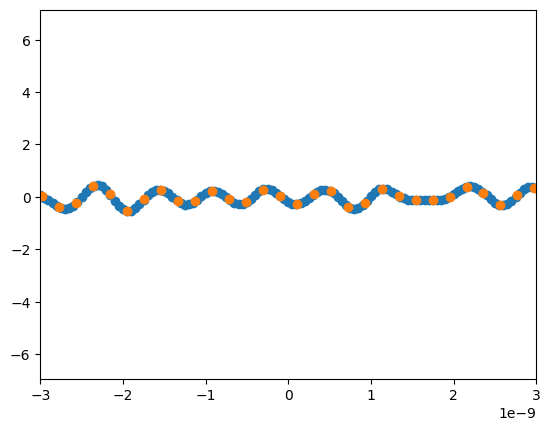

In [251]:
plt.scatter(DTSamp*np.arange(-NSampext, NSamp + 1 + NSampext)-Th/2, 
                  TrHRed[-NSampext:] + TrHRed[:NSamp + 1 + NSampext] )
plt.scatter(x_vals, y_vals)
plt.xlim([-3e-9, 3e-9])



========> 800 1 1.2499999999999998e-10 1e-07 25.600000000000005


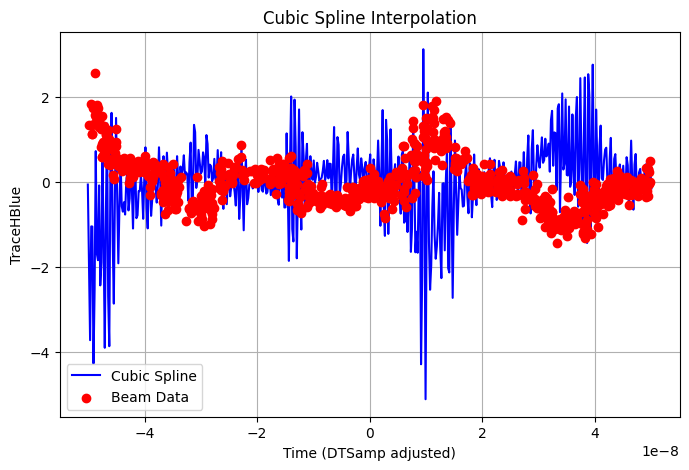

The initial emittance is 0.9998398990639595π mm*mrad
The final emittance after cooling is 0.24277710777525605π mm*mrad
Is emittance reduced? -->  True
Emittance is reduced by 75.71840171586055%
The initial rms_momentum_spread is 0.00010004049614069785 
The final rms_momentum_spread after cooling is 6.832769364426504e-06 
Is rms_momentum_spread reduced? -->  True
rms_momentum_spread is reduced by 93.16999652339106%


 =======> duration of run  971.66 s <===



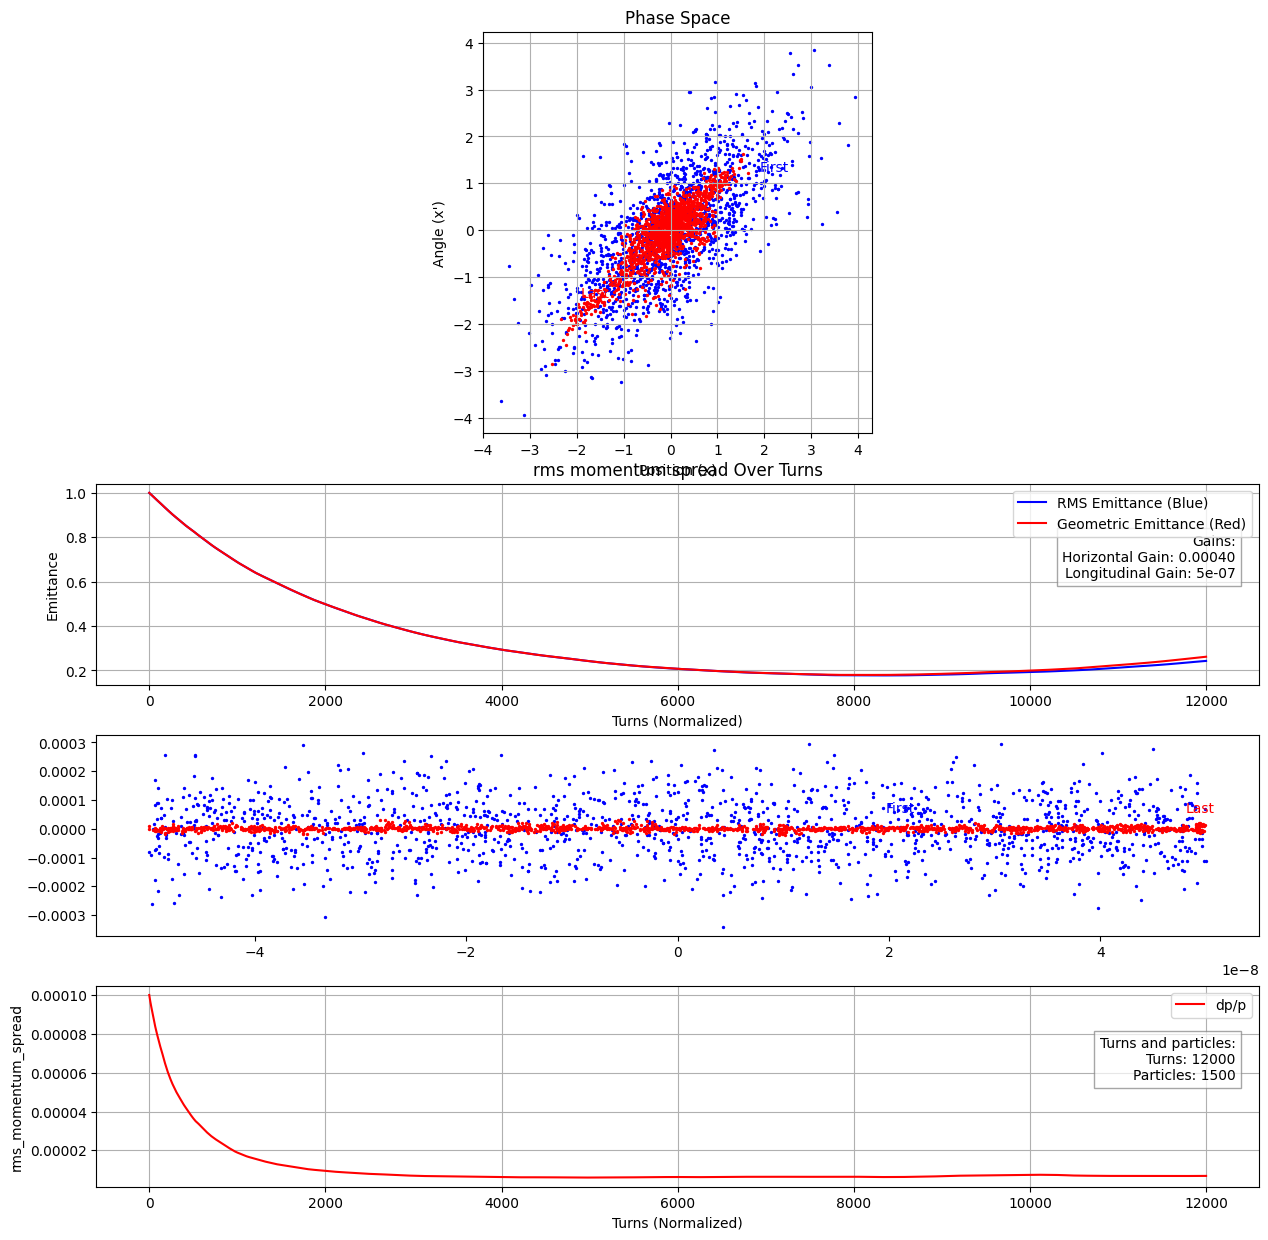

In [14]:
#we now will try to implement filter cooling....
#This will happen by keeping the signal one turn before and subtracting the current signal from it!

import cProfile
import pstats



datin  = time.time()  # record start time - to estimate run duration at end

Nparts, Nturns =  1500, 12000
betPU, alfPU       =  1.3, -0.9
betK, alfK         =  0.8,  0.6
gamPU, gamK        =  (1 + alfPU**2)/betPU, (1 + alfK**2)/betK
muPUK, muKPU       =  1.51, 2*np.pi*1.34 - 1.51
total_angle        =  2*np.pi*1.34
etaPUK, etaKPU     =  -0.01, -0.01    #eta PUK must be reletevely small, so they dont change slices so fast... 0.02 breaks the system ... It is the limit case!!!! very sensitive on etaPUK --> 2 much unwanted mixing, also etaKPU cant go very low(limit case 0.3) because then the mixing is bad
sigdelt            = .0001            # rms momentum spread in unit
Th, Trev           =  .1e-6, 5.0e-6, # half width of simulation window and revolution period in s
Tovlap, NSamp, add = 4*sigdelt*abs(etaPUK + etaKPU)*Trev, 800, '2000'
gain               =  0.0004  #as long as I reduce the eta, i have to reduce gains as well... see book
gainL              =  0.5e-6
#np.random.seed(54)

"""
wlH, wrH = -1.6e-9, 1.6e-9
def respH(Dt):
    if Dt < 1. * wlH or Dt > 1. * wrH:
        print(f' ===> function respH called with Dt ={1e6*Dt:8.4f}')
    return 0.5 * (1 + np.cos((2 * np.pi / wrH) * Dt))


"""
emittance_individual_particles = np.zeros((Nturns+2, 10))
# definition of the transverse "response function", which is given by the 
#    routine resp for the interval -wlH < Dt < wrH and 0 outside

""""
def time_function(func):
    #Decorator to measure the execution time of a function.
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed = end_time - start_time
        print(f"{func.__name__} executed in {elapsed:.6f} seconds.")
        return result
    return wrapper
"""

wlH, wrH = -1.6e-9, 1.6e-9
wlL, wrL = -1.6e-9, 1.6e-9

def respH( Dt ):
    if Dt < 1.*wlH or Dt > 1.*wrH:
        print( f' ===> function respH called with Dt ={1e6*Dt:8.4f}' )
    return (1 - 27e18*Dt**2)*(1 - 3.e18*Dt**2)*(1 - 1.15e18*Dt**2)*(1 - (.625e9*Dt)**2)**7
#   return (1 - 23e16*Dt**2)*(1 - 3.e16*Dt**2)*(1 - 1.15e16*Dt**2)*(1 - (.625e8*Dt)**2)**7
#   return (1 - 25e-12*Dt^2)*(1 - 3e-12*Dt^2)*(1 - 1.15e-12*Dt^2)*(1 - (Dt/1.5)^2)^6


def respL( Dt ):
    if Dt < 1.*wlL or Dt > 1.*wrL:
        print( f' ===> function respL called with Dt ={1e6*Dt:8.4f}' )
    return (63e9*Dt)*(1 - 6.5e18*Dt**2)*(1 - 1.55e18*Dt**2)*(1 - (.625e9*Dt)**2)**8

#rng = np.random.default_rng(18022005)


rng = np.random.default_rng(227540576 )   #this gives us the random seed!!!!

# Total width (particles of both colors) of beam time window is 2*Th ('h' for half)
#  for sampling each sub-window (red or blue) divided into NSamp intervals. This
#  means samp,ing rate DTsamp and NSamp + 1 points. On both ends to be added 
#  ceiling( Tovlap/DTSamp ) points   
DTSamp   = Th/NSamp
NSampext = math.ceil( Tovlap/DTSamp )

print('========>', NSamp, NSampext, DTSamp, Th, (wrH - wlH)/DTSamp)

# Routine to do do the exchange of .. ended up by regrouping from scratch

#@time_function
def PartsExchange( ptsEarly, ptsLate ):
    ptsEarlyNew, ptsLateNew = [], []
    for x, xp, delt, Tau in ptsEarly:
        if Tau < Th/2:  # should remain in "early group
            ptsEarlyNew += [ [x, xp, delt, Tau] ]
        else:
            ptsLateNew += [ [x, xp, delt, Tau - Th] ]
    for x, xp, delt, Tau in ptsLate:
        if Tau > -Th/2:
            ptsLateNew += [ [x, xp, delt, Tau] ]
        else:
            ptsEarlyNew += [ [x, xp, delt, Tau + Th] ]
    return ptsEarlyNew, ptsLateNew

# Routine to generate time traces
#@time_function
def TimeTraces( ptsEarly, ptsMain, ptsLate ):
    TraceH = [ 0. for _ in range(NSamp + 1 + 2*NSampext) ]
    TraceL = [ 0. for _ in range(NSamp + 1 + 2*NSampext) ]
#   first generate transverse trace
    for x, xp, delt, Tau in ptsEarly:    #precious slice than the one under investigation
        for ind in range( max(-NSampext, math.ceil((wlH+Tau-Th+Th/2)/DTSamp)), 
                          min(NSamp+1+NSampext, math.ceil((wrH+Tau-Th+Th/2)/DTSamp)) ):
            TraceH[ind] += x*respH(ind*DTSamp -Th/2- (Tau-Th) )
    for x, xp, delt, Tau in ptsMain:     #slice under investigation
        for ind in range( max(-NSampext, math.ceil((wlH+Tau+Th/2)/DTSamp)), 
                          min(NSamp+1+NSampext, math.ceil((wrH+Tau+Th/2)/DTSamp)) ):
            TraceH[ind] += x*respH(ind*DTSamp-Th/2 - Tau )
    for x, xp, delt, Tau in ptsLate:       #next slice un h) )
        for ind in range( max(-NSampext, math.ceil((wlH+Tau+Th+Th/2)/DTSamp)), 
                          min(NSamp+1+NSampext, math.ceil((wrH+Tau+Th+Th/2)/DTSamp)) ):
            TraceH[ind] += x*respH(ind*DTSamp -Th/2- (Tau+Th) )
    for x, xp, delt, Tau in ptsEarly:
        for ind in range( max(-NSampext, math.ceil((wlL+Tau-Th+Th/2)/DTSamp)), 
                          min(NSamp+1+NSampext, math.ceil((wrL+Tau-Th+Th/2)/DTSamp)) ):
            TraceL[ind] += respL(ind*DTSamp -Th/2- (Tau-Th) )
    for x, xp, delt, Tau in ptsMain:
        for ind in range( max(-NSampext, math.ceil((wlL+Tau+Th/2)/DTSamp)), 
                          min(NSamp+1+NSampext, math.ceil((wrL+Tau+Th/2)/DTSamp)) ):
            TraceL[ind] += respL(ind*DTSamp -Th/2- Tau )
    for x, xp, delt, Tau in ptsLate:
        for ind in range( max(-NSampext, math.ceil((wlL+Tau+Th+Th/2)/DTSamp)), 
                          min(NSamp+1+NSampext, math.ceil((wrL+Tau+Th+Th/2)/DTSamp)) ):
            TraceL[ind] += respL(ind*DTSamp -Th/2- (Tau+Th) )
    return TraceH, TraceL


#@time_function
def kickH(pts, signalH):
    corrected_pts = []
    for x, xp, delt, Tau in pts:
        # Interpolate signalH at the particle's Tau
        signal_value = signalH(Tau)
        # Correct xp using the signal value (define your correction logic)
        corrected_xp = xp +gain * signal_value  # I add the signal!!!!!
        # Append the updated particle to the new list
        corrected_pts.append([x, corrected_xp, delt, Tau])
    return corrected_pts
#@time_function
def kickL(pts, signalL):
    corrected_pts = []
    for x, xp, delt, Tau in pts:
        # Interpolate signalL at the particle's Tau
        signal_value = signalL(Tau)
        # Correct xp using the signal value (define your correction logic)
        corrected_delt = delt + gainL * signal_value  # Example: subtracting scaled signal
        # Append the updated particle to the new list
        corrected_pts.append([x, xp, corrected_delt, Tau])
    return corrected_pts
#@time_function
def compute_cubic_spline(DTSamp, NSampext, NSamp, Th, TrHBlue):
    return sp.interpolate.CubicSpline(
        DTSamp * np.arange(-NSampext, NSamp + 1 + NSampext) - Th / 2,
        TrHBlue[-NSampext:] + TrHBlue[:NSamp + 1 + NSampext]
    )

# Computation of transverse transfer matrix elements
projPU11 =  betPU**(1/2)
projPU21 = -alfPU/betPU**(1/2)
projPU22 =  1/betPU**(1/2)

matPUK11 = ((betK/betPU)**(1/2))*(np.cos(muPUK) + alfPU*np.sin(muPUK))
matPUK12 = ((betPU*betK)**(1/2))*np.sin(muPUK)
matPUK21 = ((alfPU-alfK)*np.cos(muPUK) - (1+alfPU*alfK)*np.sin(muPUK))/((betPU*betK)**(1/2))
matPUK22 = ((betPU/betK)**(1/2))*(np.cos(muPUK) - alfK*np.sin(muPUK))

matKPU11 = ((betPU/betK)**(1/2))*(np.cos(muKPU) + alfK*np.sin(muKPU))
matKPU12 = ((betPU*betK)**(1/2))*np.sin(muKPU)
matKPU21 = ((alfK-alfPU)*np.cos(muKPU) - (1+alfPU*alfK)*np.sin(muKPU))/((betPU*betK)**(1/2))
matKPU22 = ((betK/betPU)**(1/2))*(np.cos(muKPU) - alfPU*np.sin(muKPU))

# Generate macroparticles in two groups with red ones and blue ones
#    .. say we start with red particles the early ones
ptsRed  = []
ptsBlue = []
for _ in range(Nparts):
    Tau = rng.uniform(-Th, Th)
    xn, xpn, deltn = rng.normal(0., 1.), rng.normal(0., 1.), rng.normal(0., 1.)
    if Tau < 0: 
        ptsRed += [ [projPU11*xn, projPU21*xn + projPU22*xpn, 
                     deltn*sigdelt, Tau + Th/2] ]
    else:
        ptsBlue += [ [projPU11*xn, projPU21*xn + projPU22*xpn, 
                      deltn*sigdelt, Tau - Th/2] ]


emittance=np.zeros(Nturns+2)
geo_emittance=np.zeros(Nturns+2)
beam=[]
xp_beam=[]
x_beam=[]
beam=ptsRed+ptsBlue
beam = np.array(beam)
x_beam=beam[:,0]
xp_beam=beam[:,1]
x_initial=x_beam
xp_initial=xp_beam
tau_initial=beam[:,3]
delt_initial=beam[:,2]
emittance[0]=np.sqrt(np.mean(x_initial**2)*np.mean(xp_initial**2)-np.mean(x_initial*xp_initial)**2)   
geo_emittance[0]=((gamPU*np.mean(x_initial**2)+2*alfPU*np.mean(x_initial*xp_initial)+betPU*np.mean(xp_initial**2)))/2
emittance_individual_particles[0][:]=(gamPU*x_beam[:10]**2+2*alfPU*(x_beam[:10]*xp_beam[:10])+betPU*(xp_beam[:10]**2))/2



# Track red (now early) particles ones once around
ptsRedprev = ptsRed
ptsRed = [ [matPUK11*x + matPUK12*xp, matPUK21*x + matPUK22*xp, delt, 
            Tau + etaPUK*delt*Trev] for x, xp, delt, Tau in ptsRed ]  # no action at kicker
ptsRed = [ [matKPU11*x + matKPU12*xp, matKPU21*x + matKPU22*xp, delt, 
            Tau + etaKPU*delt*Trev] for x, xp, delt, Tau in ptsRed]

# Prepare for tracking of blue particles and track them once around
ptsBlue, ptsRed = PartsExchange( ptsBlue, ptsRed )
ptsBlueprev = ptsBlue
TrHBlue, TrLBlue = TimeTraces( ptsRedprev, ptsBlue, ptsRed )
ptsBlue = [ [matPUK11*x + matPUK12*xp, matPUK21*x + matPUK22*xp, delt, 
            Tau + etaPUK*delt*Trev] for x, xp, delt, Tau in ptsBlue ]  # no action at kicker
#ptsBlue=kickH(ptsBlue,cs)
ptsBlue = [ [matKPU11*x + matKPU12*xp, matKPU21*x + matKPU22*xp, delt, 
            Tau + etaKPU*delt*Trev] for x, xp, delt, Tau in ptsBlue]

TrHBlue_prev, TrLBlue_prev = TrHBlue, TrLBlue

# Prepare for 2nd tracking of red particles and track them once around
ptsRed, ptsBlue = PartsExchange( ptsRed, ptsBlue )
ptsRedprev = ptsRed
TrHRed, TrLRed = TimeTraces( ptsBlueprev, ptsRed, ptsBlue )
#cs = sp.interpolate.CubicSpline( DTSamp*np.arange(-NSampext, NSamp + 1 + NSampext)-Th/2, 
 #                 TrHRed[-NSampext:] + TrHRed[:NSamp + 1 + NSampext] )
ptsRed = [ [matPUK11*x + matPUK12*xp, matPUK21*x + matPUK22*xp, delt, 
            Tau + etaPUK*delt*Trev] for x, xp, delt, Tau in ptsRed ]  # no action at kicker
#ptsRed=kickH(ptsRed,cs)
ptsRed = [ [matKPU11*x + matKPU12*xp, matKPU21*x + matKPU22*xp, delt, 
            Tau + etaKPU*delt*Trev] for x, xp, delt, Tau in ptsRed]

TrHRed_prev, TrLRed_prev = TrHRed, TrLRed
# Now the blue ones are early - now just enter loop over number of turns
#   later - for longitudinal filter cooling - some more tracking will be needed

beam=[]
xp_beam=[]
x_beam=[]
beam=ptsRed+ptsBlue
beam = np.array(beam)
x_beam=beam[:,0]
xp_beam=beam[:,1]
emittance[1]=np.sqrt(np.mean(x_beam**2)*np.mean(xp_beam**2)-np.mean(x_beam*xp_beam)**2) 
emittance_individual_particles[1][:]=(gamPU*x_beam[:10]**2+2*alfPU*(x_beam[:10]*xp_beam[:10])+betPU*(xp_beam[:10]**2))/2
rms_momentum_spread=np.zeros(Nturns)

# Now we can go in loop and even implement transverse cooling or longitudinal time delay cooling (but not filter)
for turn in range(Nturns):
    #print(f' turn {turn:5d} after {(time.time() - datin):8.2f} s <===')
#   Get ready for the blue particles to be tracked and track them to kicker
    ptsBlue, ptsRed = PartsExchange( ptsBlue, ptsRed )
    ptsBlueprev, TrLBlueprev = ptsBlue, TrLBlue  # Keep longitudinal trace to add filter cooling later
    TrHBlue, TrLBlue = TimeTraces( ptsRedprev, ptsBlue, ptsRed )
    #TrHDiffBlue = [h - l for h, l in zip(TrHBlue_prev, TrHBlue)]
    TrLDiffBlue = [h - l for h, l in zip(TrLBlue_prev, TrLBlue)]
    #if len(TrLDiffRed)!= len(TrLBlue_prev) or len(TrLDiffRed)!= len(TrLBlue):
     #   print(f"ERROR")
    #TrLDiffBlue=np.array(TrLBlue_prev)-np.array(TrLBlue)
   
    cs = compute_cubic_spline(DTSamp, NSampext, NSamp, Th, TrHBlue)

    csL=compute_cubic_spline(DTSamp, NSampext, NSamp, Th, TrLDiffBlue)
    #cs = sp.interpolate.interp1d( DTSamp*np.arange(-NSampext, NSamp + 1 + NSampext)-Th/2, 
     #             TrHBlue[-NSampext:] + TrHBlue[:NSamp + 1 + NSampext] )
    #csL=sp.interpolate.interp1d( DTSamp*np.arange(-NSampext, NSamp + 1 + NSampext)-Th/2, 
     #             TrLBlue[-NSampext:] + TrLBlue[:NSamp + 1 + NSampext] )

    #print(len(TrHBlue))
    ptsBlue = [ [matPUK11*x + matPUK12*xp, matPUK21*x + matPUK22*xp, delt, 
                 Tau + etaPUK*delt*Trev] for x, xp, delt, Tau in ptsBlue ]
#   One day cooling to be applied -  now just dump time traces instead
    ptsBlue=kickH(ptsBlue,cs)
    ptsBlue=kickL(ptsBlue,csL)
#   track the blue one further to the PU
    ptsBlue = [ [matKPU11*x + matKPU12*xp, matKPU21*x + matKPU22*xp, delt, 
                 Tau + etaKPU*delt*Trev] for x, xp, delt, Tau in ptsBlue ]
    
    TrHBlue_prev, TrLBlue_prev = TrHBlue, TrLBlue
#   Get ready for the red particles to be tracked and track them to kicker
    ptsRed, ptsBlue = PartsExchange( ptsRed, ptsBlue )
    ptsRedprev, TrLRedprev = ptsRed, TrLRed  # Keep longitudinal trace to add filter cooling later
    TrHRed, TrLRed = TimeTraces( ptsBlueprev, ptsRed, ptsBlue )
    #TrHDiffRed= [h - l for h, l in zip(TrHRed_prev, TrHRed)]
    TrLDiffRed = [h - l for h, l in zip(TrLRed_prev, TrLRed)]
    #TrLDiffRed=np.array(TrLRed_prev)-np.array(TrLRed)
    
    cs= compute_cubic_spline(DTSamp, NSampext, NSamp, Th, TrHRed)
    csL=compute_cubic_spline(DTSamp, NSampext, NSamp, Th, TrLDiffRed)
    x_vals = np.linspace(-Th/2 - NSampext * DTSamp, (NSamp + NSampext) * DTSamp - Th/2, 500)
    y_vals = cs(x_vals)
    #print("Spline Knots:", cs.x)  # Knots where the spline pieces join
    #print("Spline Coefficients:", cs.c)  # Coefficients of the spline pieces
   
    tauPU=[]
    xPU=[]
    beam=ptsRed
    beam = np.array(beam)
    tauPU=beam[:,3]
    xPU=beam[:,0]
    
# Plot the spline
    if turn==Nturns-1:
     plt.figure(figsize=(8, 5))
     plt.plot(x_vals, y_vals, label='Cubic Spline', color='blue')
    #plt.scatter(cs.x, cs(cs.x), color='red', label='Data Points', zorder=5)  # Interpolated points
     plt.scatter(tauPU,xPU, color='red', label='Beam Data', zorder=5)  # Use scatter for point data
     plt.title('Cubic Spline Interpolation')
     plt.xlabel('Time (DTSamp adjusted)')
     plt.ylabel('TraceHBlue')
     plt.legend()
     plt.grid(True)
     plt.show()

     
    ptsRed = [ [matPUK11*x + matPUK12*xp, matPUK21*x + matPUK22*xp, delt, 
                Tau + etaPUK*delt*Trev] for x, xp, delt, Tau in ptsRed ]
#   One day cooling(s) to be applied - now just dump time traces instead
    ptsRed=kickH(ptsRed,cs)
    ptsRed=kickL(ptsRed,csL)   #time of flight method longitudinal cooling
#   track the red ones further to the PU, where they will be the late ones
    ptsRed = [ [matKPU11*x + matKPU12*xp, matKPU21*x + matKPU22*xp, delt, 
                Tau + etaKPU*delt*Trev] for x, xp, delt, Tau in ptsRed ] 
    
    TrHRed_prev, TrLRed_prev = TrHRed, TrLRed


    beam=[]
    xp_beam=[]
    x_beam=[]
    delta_beam=[]
    dlt_final=[]
    tau_final=[]
    beam=ptsRed+ptsBlue
    beam = np.array(beam)
    x_beam=beam[:,0]
    xp_beam=beam[:,1]
    delta_beam=beam[:,2]
    tau_final=beam[:,3]
    dlt_final=beam[:,2]
    emittance[turn+2]=np.sqrt(np.mean(x_beam**2)*np.mean(xp_beam**2)-np.mean(x_beam*xp_beam)**2)
    geo_emittance[turn+2]=(gamPU*np.mean(x_beam**2)+2*alfPU*np.mean(x_beam*xp_beam)+betPU*np.mean(xp_beam**2))/2
    rms_momentum_spread[turn]=np.sqrt(np.mean(delta_beam**2)-np.mean(delta_beam)**2)
    #emittance_individual_particles[turn+2][:]=(gamPU*x_beam[:10]**2+2*alfPU*(x_beam[:10]*xp_beam[:10])+betPU*(xp_beam[:10]**2))/2

print(f'The initial emittance is {emittance[0]}{chr(0x03C0)} mm*mrad')
print(f'The final emittance after cooling is {emittance[-1]}{chr(0x03C0)} mm*mrad')
print(f'Is emittance reduced? -->  {emittance[-1] < emittance[0]}')
if emittance[-1] < emittance[0]:
  print(f"Emittance is reduced by {(emittance[0] - emittance[-1]) * 100 / emittance[0]}%")
print(f'The initial rms_momentum_spread is {rms_momentum_spread[0]} ')
print(f'The final rms_momentum_spread after cooling is {rms_momentum_spread[-1]} ')
print(f'Is rms_momentum_spread reduced? -->  {rms_momentum_spread[-1] < rms_momentum_spread[0]}')
if rms_momentum_spread[-1] < rms_momentum_spread[0]:
  print(f"rms_momentum_spread is reduced by {(rms_momentum_spread[0] - rms_momentum_spread[-1]) * 100 / rms_momentum_spread[0]}%")


fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    4, 1, figsize=(15, 15), gridspec_kw={'height_ratios': [2, 1, 1, 1]}
)

# First plot: Phase Space
ax1.scatter(x_initial, xp_initial, color='blue', s=2, label='First Element')
ax1.scatter(x_beam, xp_beam, color='red', s=2, label='Last Element')
ax1.annotate('First', (x_initial[0], xp_initial[0]), textcoords="offset points", xytext=(0, 10), ha='center', color='blue')
ax1.annotate('Last', 
             (x_beam[-1], xp_beam[-1]), 
             textcoords="offset points", 
             xytext=(0, 10), 
             ha='center', 
             color='red')

ax1.set_xlabel('Position (x)')
ax1.set_ylabel("Angle (x')")
ax1.set_title('Phase Space')
ax1.grid(True)
ax1.set_aspect('equal', adjustable='box')

# Second plot: Emittance vs Turns
pa = np.arange(0, Nturns ) * total_angle


# Plot RMS Emittance (Blue Curve)
ax2.plot(pa / total_angle, emittance[2:], label='RMS Emittance (Blue)', color='blue')

# Plot Geometric Emittance (Red Curve)
ax2.plot(pa / total_angle, geo_emittance[2:], label='Geometric Emittance (Red)', color='red')

# Add labels and title
ax2.set_xlabel('Turns (Normalized)')
ax2.set_ylabel('Emittance')
ax2.set_title('Beam Emittance Over Turns')
ax2.grid(True)
# Add a legend
ax2.legend(loc='upper right')
gains_text = f"Gains:\nHorizontal Gain: {gain:.5f}\nLongitudinal Gain: {gainL}"
ax2.text(0.98, 0.75, gains_text,  # Adjust the y-coordinate to position below the legend
         transform=ax2.transAxes,  # Relative to the axes (0=left, 1=right)
         fontsize=10,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7))  # Optional box for visibility
ax3.scatter(tau_initial, delt_initial, color='blue', s=2, label='First Element')
ax3.scatter(tau_final, dlt_final, color='red', s=2, label='Last Element')
ax3.annotate('First', (tau_initial[0], delt_initial[0]), textcoords="offset points", xytext=(0, 10), ha='center', color='blue')
ax3.annotate('Last', (tau_final[-1], dlt_final[-1]), textcoords="offset points", xytext=(0, 10),ha='center', color='red')  



# Plot Geometric Emittance (Red Curve)
ax4.plot(pa / total_angle, rms_momentum_spread, label='dp/p', color='red')

# Add labels and title
ax4.set_xlabel('Turns (Normalized)')
ax4.set_ylabel('rms_momentum_spread')
ax2.set_title('rms momentum spread Over Turns')
ax4.grid(True)
# Add a legend
ax4.legend(loc='upper right')
N_text = f"Turns and particles:\nTurns: {Nturns}\nParticles: {Nparts}"
ax4.text(0.98, 0.75, N_text,  # Adjust the y-coordinate to position below the legend
         transform=ax4.transAxes,  # Relative to the axes (0=left, 1=right)
         fontsize=10,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7))  # Optional box for visibility




print(f'\n\n =======> duration of run{(time.time() - datin):8.2f} s <===\n')
